Scenario 1: n Prediction (Instantaneous Data / "Virtual Sensor"):

This model provides the best possible estimate of the force at the current moment (Y t Assumption: The controller loop is able to handle the 0.005 delay due to overall system latency due to communication/computation/

---> No batching is used, treating as tabular Data (Since this is creating a "virtual sensor"), not anticipation of future force/ fault.

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import randint, loguniform
import xgboost as xgb
!pip install tensorflow
!pip install scikeras
!pip install keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf # Import tensorflow
import keras_tuner as kt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/'

# Load the splits
with open(f"{checkpoints_path}checkpoint.pkl", 'rb') as f:
    checkpoints = pickle.load(f)

# Load the feature & target transformers
with open(checkpoints_path + 'power_transformer.pkl','rb') as f:
    pt_dict = pickle.load(f)
pt_X, pt_y = pt_dict['fea'], pt_dict['tar']

# Extract X/y
X_train, y_train = checkpoints['train']['X'], checkpoints['train']['y']
X_val,   y_val   =  checkpoints['val']['X'], checkpoints['val']['y']
X_test,  y_test  =  checkpoints['test']['X'], checkpoints['test']['y']
X_test2pred =  checkpoints['test2predict']['X']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_test2pred shape:", X_test2pred.shape)

# Concatenate your train and val sets so that CV can index into them
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

val_fold = np.array([-1]*1000 + [ 0]*1000 )
ps = PredefinedSplit(val_fold)

val_fold_slice = np.array([-1]*500 + [0]*500)
ps_slice = PredefinedSplit(val_fold_slice)


X_sample   = X_combined.iloc[:1000]
y_sample   = y_combined.iloc[:1000]


X_train shape: (209809, 18)
y_train shape: (209809, 3)
X_val shape: (84524, 18)
y_val shape: (84524, 3)
X_test shape: (84490, 18)
y_test shape: (84490, 3)
X_test2pred shape: (125243, 18)


In [ ]:
with open(f'{checkpoints_path}power_transformer.pkl','rb') as f:
    fitted_tf = pickle.load(f)
pt_X = fitted_tf['fea']
pt_Y = fitted_tf['tar']

In [ ]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
import numpy as np


def inv_transform_preds(y_pred_t, pt_y):
    # Directly inverse-transform the full array:
    return pt_y.inverse_transform(y_pred_t)


def mae_orig(y_true, y_pred_t, pt_y):
    y_pred = inv_transform_preds(y_pred_t, pt_y)
    return mean_absolute_error(y_true, y_pred)

def mape_orig(y_true, y_pred_t, pt_y):
    y_pred = inv_transform_preds(y_pred_t, pt_y)
    return mean_absolute_percentage_error(y_true, y_pred)

# Wrap them for RandomizedSearchCV:
MAE_SCORER  = make_scorer(lambda y_true, y_pred: mae_orig(y_true, y_pred, pt_y=pt_Y), greater_is_better=False)
MAPE_SCORER = make_scorer(lambda y_true, y_pred: mape_orig(y_true, y_pred, pt_y=pt_Y), greater_is_better=False)

In [ ]:
def tune_model_with_val(pipe, params, Xc, yc, predefined_split):
    """
    Runs RandomizedSearchCV using a PredefinedSplit so that
    the second fold is exactly your held-out validation set.
    """
    rs = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=50,
        cv=predefined_split,
        scoring={'MAE': MAE_SCORER, 'MAPE': MAPE_SCORER},
        refit='MAE',
        n_jobs=3,
        verbose=2
    )
    rs.fit(Xc, yc)
    return rs


def eval_model_raw(model, X, y_true, pt_Y):
    # Predict in transformed space
    y_pred_t = model.predict(X)

    # Ensure y_pred_t is a 2D array
    if y_pred_t.ndim == 1:
        y_pred_t = y_pred_t.reshape(-1, 1)

    # If pt_Y expects feature names, convert to DataFrame with appropriate column names
    if hasattr(pt_Y, 'feature_names_in_'):
        y_pred_t = pd.DataFrame(y_pred_t, columns=pt_Y.feature_names_in_)

    # Inverse-transform back to original scale
    y_pred = pt_Y.inverse_transform(y_pred_t)

    # Ensure y_true is a 2D array
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    # If pt_Y expects feature names, convert y_true to DataFrame
    if hasattr(pt_Y, 'feature_names_in_'):
        y_true = pd.DataFrame(y_true, columns=pt_Y.feature_names_in_)

    y_true_inv = pt_Y.inverse_transform(y_true)

    print("MAE :", mean_absolute_error(y_true_inv, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true_inv, y_pred))

    return y_true_inv, y_pred



In [ ]:
# --- 3a) RF (no scaling, verbose) ----
random_forest = RandomForestRegressor(random_state=42)
rf_mo = MultiOutputRegressor(random_forest, n_jobs=3)
rf_pipe = Pipeline([('rf', rf_mo)])
rf_params = {
    'rf__estimator__n_estimators': [900, 1100, 1300],
    'rf__estimator__max_depth': [10, 20, 30],
    'rf__estimator__min_samples_split': [30, 50],
    'rf__estimator__min_samples_leaf': [5, 10],
    'rf__estimator__max_features': ['log2', 'sqrt']
}


# --- 3b) Decision Tree (verbose) ----
dt_base = DecisionTreeRegressor(random_state=42)
dt_mo   = MultiOutputRegressor(dt_base, n_jobs=3)
dt_pipe = Pipeline([('dt', dt_mo)])
dt_params = {
    'dt__estimator__max_depth':         randint(3, 10),
    'dt__estimator__min_samples_split': randint(2, 15),
    'dt__estimator__min_samples_leaf':  randint(1, 15)
}

# --- 3c) XGBoost (verbose) ----
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=1)
xgb_mo   = MultiOutputRegressor(xgb_base, n_jobs=3)
xgb_pipe = Pipeline([('xgb', xgb_mo)])
xgb_params = {
    'xgb__estimator__n_estimators':     randint(500, 1500),
    'xgb__estimator__learning_rate':   loguniform(1e-3, 0.3),
    'xgb__estimator__max_depth':       randint(3, 13),
    'xgb__estimator__subsample':       [0.6, 0.8, 1.0],
    'xgb__estimator__colsample_bytree': [0.4, 0.6, 0.8]
}

In [ ]:

# --- 3d) Deep Neural Network (verbose) ----
# Define the model building function for Keras Tuner
# Define the model building function with all tunable parameters
def build_dnn_model(hp):
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1],)))

    # Tune number of hidden layers
    n_layers = hp.Int('n_layers', min_value=1, max_value=6)
    for i in range(n_layers):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'leaky_relu', 'sigmoid', 'tanh'])
        ))
        # Add dropout after each dense layer
        model.add(Dropout(
            rate=hp.Float(f'dropout_rate_{i}', min_value=0.05, max_value=0.5, step=0.1)
        ))

    # Output layer (adjust to match target shape)
    model.add(Dense(y_train.shape[1], activation='linear'))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')
    early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae', 'mape'],
        loss='mae'
    )
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_dnn_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory=checkpoints_path,
    project_name='dnn_tuning_1'
)



Starting DNN Keras Tuner search...
DNN Keras Tuner search complete.

Best DNN Hyperparameters: {'n_layers': 5, 'units_0': 16, 'activation_0': 'relu', 'dropout_rate_0': 0.35000000000000003, 'learning_rate': 0.0011465038259544636, 'units_1': 48, 'activation_1': 'sigmoid', 'dropout_rate_1': 0.45, 'units_2': 32, 'activation_2': 'tanh', 'dropout_rate_2': 0.45, 'units_3': 128, 'activation_3': 'relu', 'dropout_rate_3': 0.15000000000000002, 'units_4': 48, 'activation_4': 'sigmoid', 'dropout_rate_4': 0.25, 'units_5': 80, 'activation_5': 'tanh', 'dropout_rate_5': 0.15000000000000002}
n_layers: 5
units_0: 16
activation_0: relu
dropout_rate_0: 0.35000000000000003
learning_rate: 0.0011465038259544636
units_1: 48
activation_1: sigmoid
dropout_rate_1: 0.45
units_2: 32
activation_2: tanh
dropout_rate_2: 0.45
units_3: 128
activation_3: relu
dropout_rate_3: 0.15000000000000002
units_4: 48
activation_4: sigmoid
dropout_rate_4: 0.25
units_5: 80
activation_5: tanh
dropout_rate_5: 0.15000000000000002
Epoch

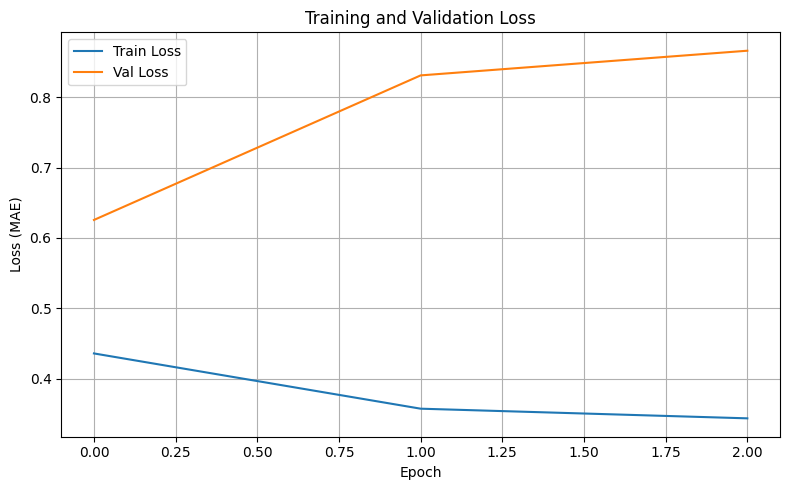

In [ ]:
print("\nStarting DNN Keras Tuner search...")
# Run the tuner search with fixed initial values for batch_size and epochs
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,            # Choose a reasonable fixed number (or set to max)
    batch_size=32,        # Use a standard batch size during tuning
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

print("DNN Keras Tuner search complete.")

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest DNN Hyperparameters: {best_hps.values}")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


# Rebuild model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Fit the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=1
)

# Save the best model
best_model.save(f'{checkpoints_path}best_dnn_model.keras')
print(f"Best DNN model saved to {checkpoints_path}best_dnn_model.keras")

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("=== DNN on Test ===-Evaluation based on Original Scale")
y_true, y_pred = eval_model_raw(best_model, X_test, y_test, pt_Y)

=== DNN on Test ===-Evaluation based on Original Scale
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MAE : 0.4523691113611199
MAPE: 3.2069318362362105


XGB

In [ ]:
xgb_rs = tune_model_with_val(xgb_pipe, xgb_params, X_combined, y_combined, ps)

# Save full CV object
with open(f'{checkpoints_path}xgb_cv.pkl','wb') as f:
    pickle.dump(xgb_rs.best_estimator_, f)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Reload later
with open(f'{checkpoints_path}xgb_cv.pkl','rb') as f:
    xgb_model = pickle.load(f)

best = xgb_model

print(best.get_params())

print("=== XGB on Test ===")
y_true, y_pred = eval_model_raw(xgb_model, X_test, y_test, pt_Y)


{'memory': None, 'steps': [('xgb', MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=np.float64(0.13922032891356131),
                                           

RF

In [ ]:
rf_rs = tune_model_with_val(rf_pipe, rf_params, X_combined, y_combined, ps)
with open(f'{checkpoints_path}rf.pkl','wb') as f:
    pickle.dump(rf_rs.best_estimator_, f)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


In [ ]:
with open(f'{checkpoints_path}rf.pkl','rb') as f:
    rf_model = pickle.load(f)

best = rf_model

print(best.get_params())

print("=== RF on Test ===")
y_true, y_pred = eval_model_raw(rf_model, X_test, y_test, pt_Y)

{'memory': None, 'steps': [('rf', MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=30,
                                                     max_features='log2',
                                                     min_samples_leaf=5,
                                                     min_samples_split=50,
                                                     n_estimators=900,
                                                     random_state=42),
                     n_jobs=3))], 'transform_input': None, 'verbose': False, 'rf': MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=30,
                                                     max_features='log2',
                                                     min_samples_leaf=5,
                                                     min_samples_split=50,
                                                     n_estimators=900,
                                                     random_state=42),
                     

DT

In [ ]:
dt_rs  = tune_model_with_val(dt_pipe, dt_params, X_combined, y_combined, ps)
with open(f'{checkpoints_path}dt.pkl','wb') as f:
    pickle.dump(dt_rs.best_estimator_, f)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


In [ ]:
with open(f'{checkpoints_path}dt.pkl','rb') as f:
    dt_model = pickle.load(f)

best = dt_model

print(best.get_params())

print("=== DecisionTree on Test ===")
y_true, y_pred = eval_model_raw(dt_model, X_test, y_test, pt_Y)

{'memory': None, 'steps': [('dt', MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     random_state=42),
                     n_jobs=3))], 'transform_input': None, 'verbose': False, 'dt': MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=9,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     random_state=42),
                     n_jobs=3), 'dt__estimator__ccp_alpha': 0.0, 'dt__estimator__criterion': 'squared_error', 'dt__estimator__max_depth': 9, 'dt__estimator__max_features': None, 'dt__estimator__max_leaf_nodes': None, 'dt__estimator__min_impurity_decrease': 0.0, 'dt__estimator__min_samples_leaf': 3, 'dt__estimator_

Plot =)

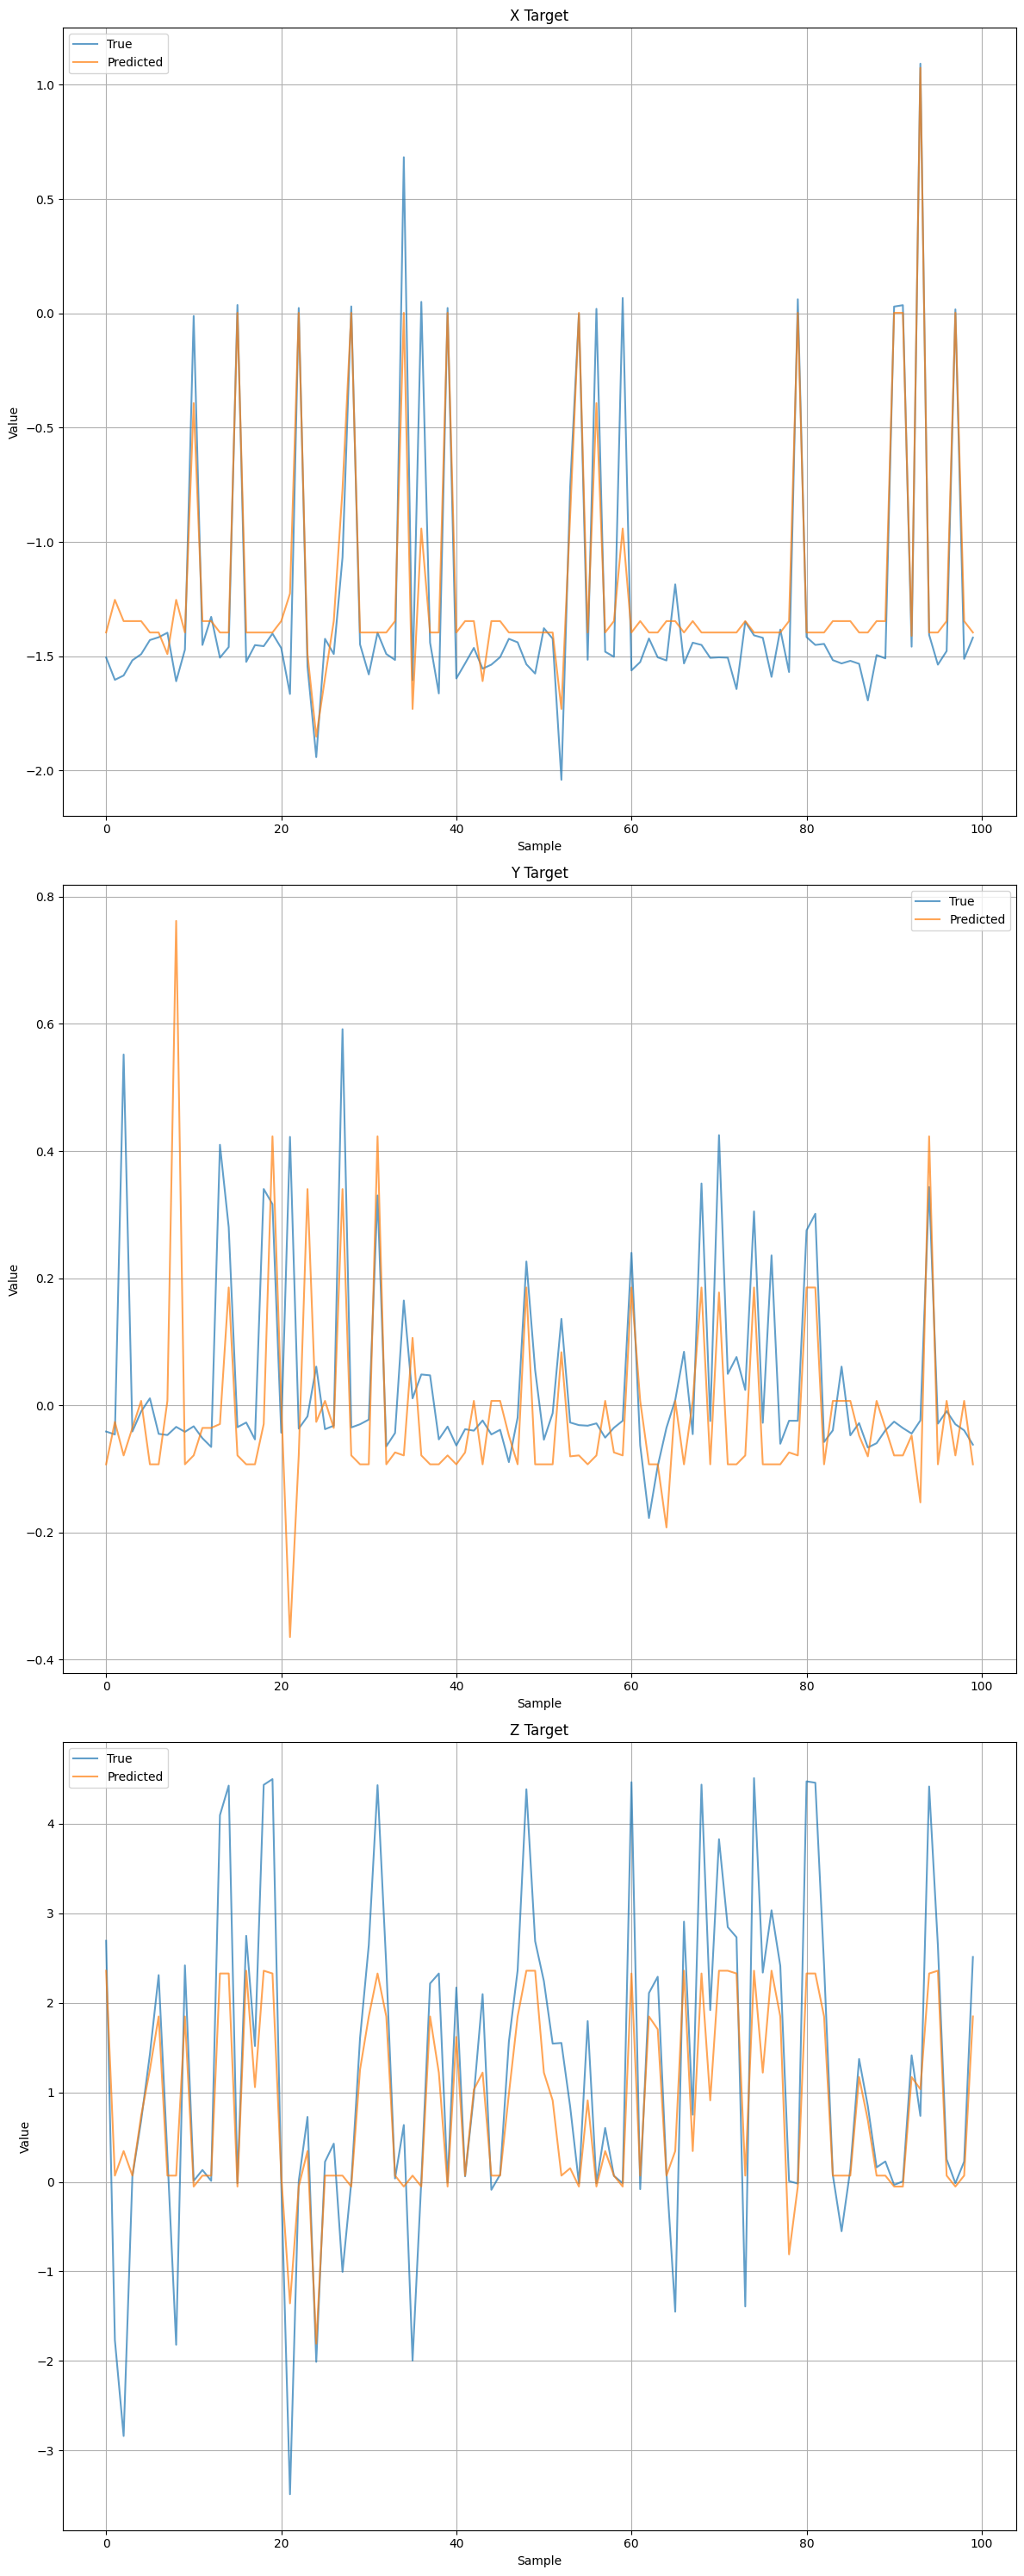

In [ ]:
# Convert to numpy arrays if needed
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Random sampling (e.g., 500 points)
np.random.seed(42)
sample_size = 100
sample_indices = np.random.choice(len(y_true), size=min(sample_size, len(y_true)), replace=False)

y_true_sampled = y_true[sample_indices]
y_pred_sampled = y_pred[sample_indices]

target_names = ['X', 'Y', 'Z']

plt.figure(figsize=(12, 30))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_true_sampled[:, i], label='True', alpha=0.7)
    plt.plot(y_pred_sampled[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{target_names[i]} Target')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



--- Generating SHAP Explanations ---

Generating SHAP for target: Z (kN)


<ipython-input-84-53e698a3c495>:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_shap, feature_names=X_for_shap.columns, show=False)


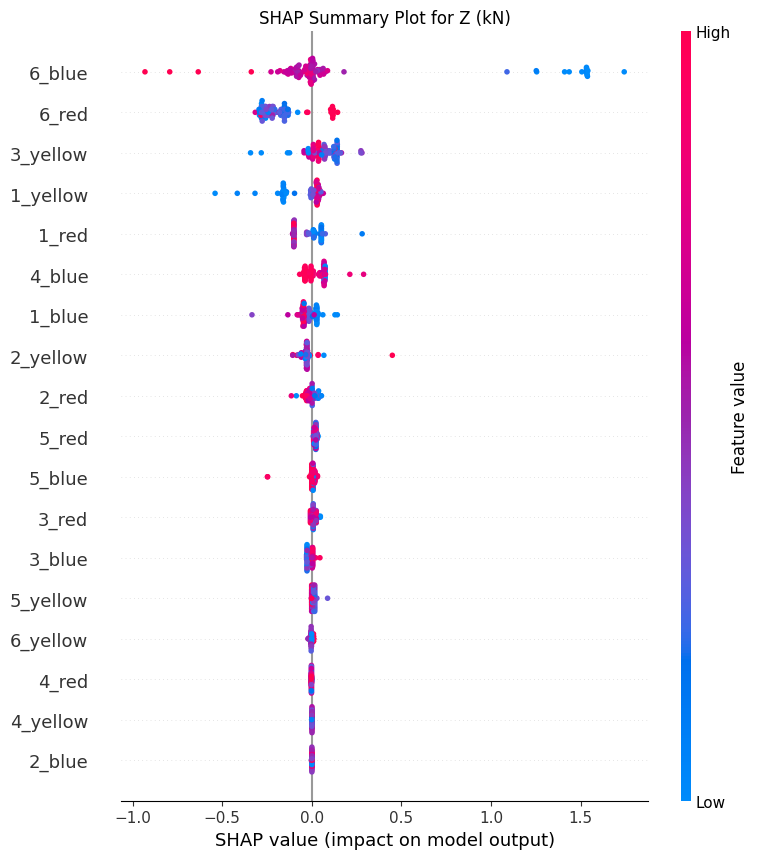


Generating SHAP for target: Y (kN)


<ipython-input-84-53e698a3c495>:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_shap, feature_names=X_for_shap.columns, show=False)


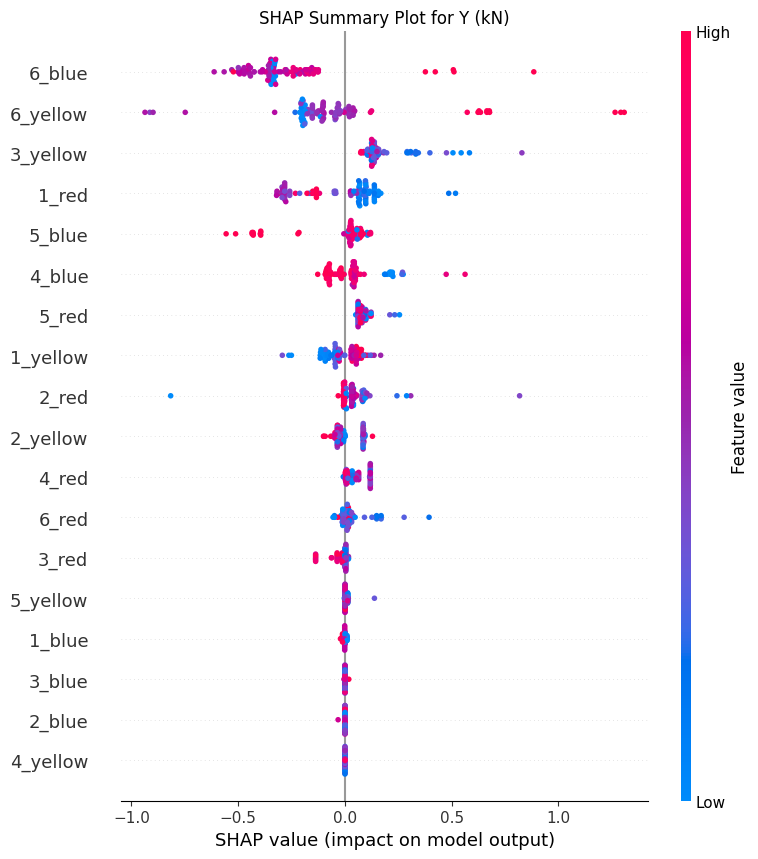


Generating SHAP for target: X (kN)


<ipython-input-84-53e698a3c495>:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_shap, feature_names=X_for_shap.columns, show=False)


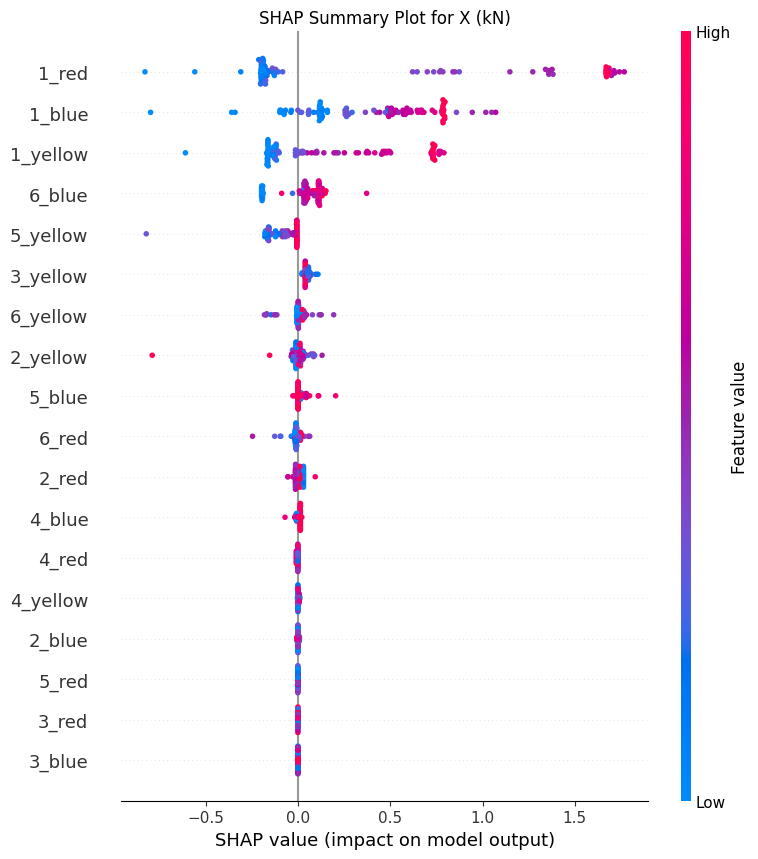

In [ ]:
!pip install shap
import shap
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import sklearn.pipeline


import shap
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

print("\n--- Generating SHAP Explanations ---")

# Sample input data for SHAP
X_for_shap = X_test.sample(n=min(100, len(X_test)), random_state=42)

# Handle MultiOutputRegressor
if isinstance(model_to_explain, MultiOutputRegressor):
    base_models = model_to_explain.estimators_
    target_names = ['Z (kN)', 'Y (kN)', 'X (kN)']  # Adjust as needed

    for i, (estimator, target_name) in enumerate(zip(base_models, target_names)):
        print(f"\nGenerating SHAP for target: {target_name}")
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_for_shap)

        shap.summary_plot(shap_values, X_for_shap, feature_names=X_for_shap.columns, show=False)
        plt.title(f'SHAP Summary Plot for {target_name}')
        plt.tight_layout()
        plt.show()
else:
    # Fallback for single-output tree model
    explainer = shap.TreeExplainer(model_to_explain)
    shap_values = explainer.shap_values(X_for_shap)
    shap.summary_plot(shap_values, X_for_shap, feature_names=X_for_shap.columns)



In [ ]:
# Choose best overall model
best = dt_model

y_sub_t = best.predict(X_test2pred)
y_sub   = inv_transform_preds(y_sub_t, pt_Y)

# Append back to DataFrame and save
df_out = X_test2pred.copy()
df_out[['Z (kN)','Y (kN)','X (kN)']] = y_sub
df_out.to_excel(f'{checkpoints_path}submission_best(Scenario1).xlsx', index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
